In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from skimage import data
import os
from skimage import io
import matplotlib.patches as patches
from skimage.io import imread
from skimage.util import img_as_ubyte
from skimage import morphology
from skimage.measure import label
from scipy import ndimage
from skimage import measure, feature
from skimage import filters, feature, segmentation
from skimage.feature import canny
from skimage.filters import sobel
from skimage.filters import laplace
from skimage import img_as_float
from skimage.filters import roberts
from skimage.color import rgb2gray
from skimage import exposure
from skimage import filters


##Get the Data
First I need to clone my GitHub to access the folder with my photos

In [3]:
!git clone https://github.com/JoeRuggieroStudent/ML_Projects.git


Cloning into 'ML_Projects'...
remote: Enumerating objects: 137, done.
remote: Counting objects: 100% (137/137), done.
remote: Compressing objects: 100% (136/136), done.
remote: Total 137 (delta 45), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (137/137), 48.99 MiB | 16.34 MiB/s, done.
Resolving deltas: 100% (45/45), done.


In [4]:
os.chdir('/content/ML_Projects/10_f_kerguelensis_photos')

In [5]:

image_files = os.listdir()
print(image_files)


['PC496_8_10cm_gpA006.jpg', 'PC496_8_10cm_gpA007.jpg', 'PC496_8_10cm_gpA008.jpg', 'PC496_8_10cm_gpA011.jpg', 'PC496_8_10cm_gpA012.jpg', 'PC496_8_10cm_gpA004.jpg', 'PC496_8_10cm_gpA005.jpg', 'PC496_8_10cm_gpA010.jpg', 'PC496_8_10cm_gpA003.jpg', 'PC496_8_10cm_gpA002.jpg']


Okay it seems as if we have 10 photos of the Southern Ocean diatom *Fragilariopsis kerguelensis* loaded in.  In this workbook, I want to do some image analysis on these ten photos.

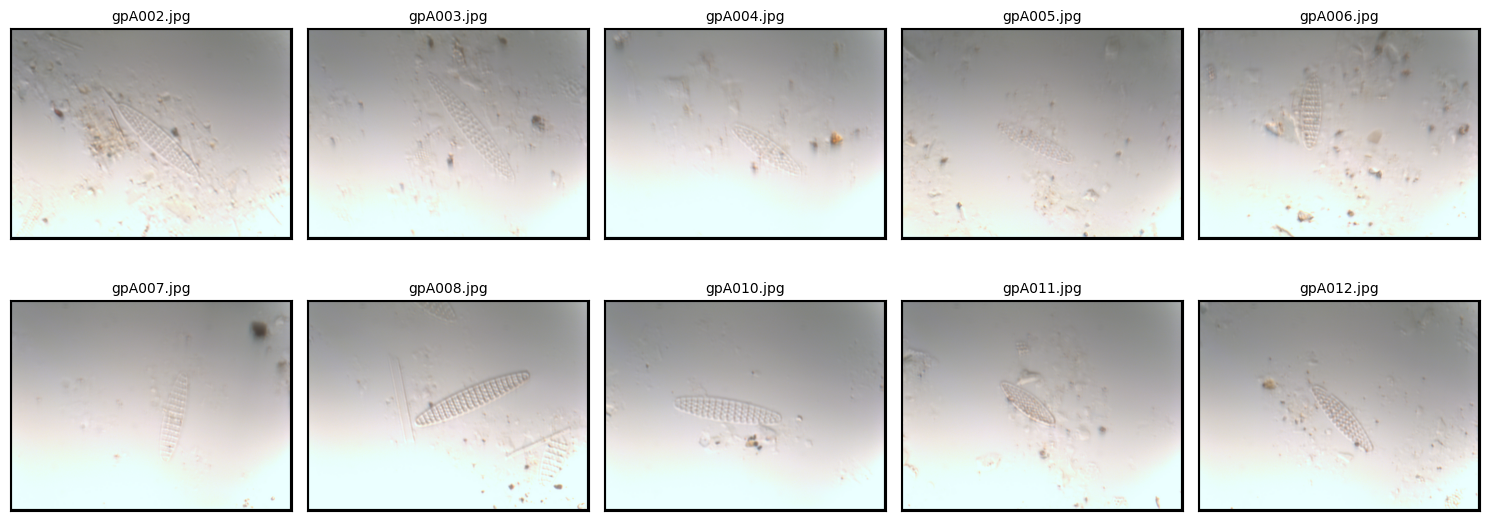

In [6]:

# Set the image directory path
image_dir = "/content/ML_Projects/10_f_kerguelensis_photos"

# Get all image files (assuming they are .jpg or .png)
image_files = sorted([f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png', '.jpeg'))])

# Create a 2x5 figure
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

# Loop through images and plot
for ax, img_file in zip(axes.flatten(), image_files):
    img_path = os.path.join(image_dir, img_file)
    image = imread(img_path)

    # Clean the filename (remove 'PC496_8_10cm')
    clean_title = img_file.replace("PC496_8_10cm", "").replace("_", " ").strip()

    # Display image
    ax.imshow(image, cmap="gray")
    ax.set_xticks([])
    ax.set_yticks([])

    # Add cleaned title
    ax.set_title(clean_title, fontsize=10, pad=5)

    # Add black border around the image
    rect = patches.Rectangle(
        (0, 0), image.shape[1], image.shape[0], linewidth=3, edgecolor="black", facecolor="none"
    )
    ax.add_patch(rect)

# Adjust spacing
plt.tight_layout()
plt.show()



Each one of these photos contains the diatom *Fragilariopsis kerguelensis*, which is a Southern Ocean diatom that lives in the open ocean.  I want to see if we can use canny edge detection to pick out the edge of each.  We'll first convert it to greyscale, and then well apply canny edge detection, and then see if the program can visualize the diatom we are looking for.  We'll just use one image to start with, the one that I think will have the most success because its rim sticks out to human eyes the best

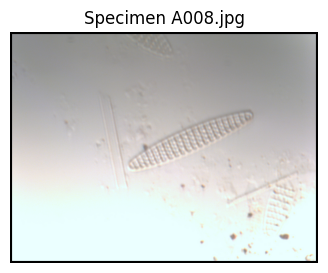

In [7]:

# Set the path to the specific image
img_path = "/content/ML_Projects/10_f_kerguelensis_photos/PC496_8_10cm_gpA008.jpg"

# Read and display the image
image = imread(img_path)

# Display the image
fig, ax = plt.subplots(figsize=(4, 3))
ax.imshow(image)

# Add black border around the image
rect = patches.Rectangle((0, 0), image.shape[1], image.shape[0], linewidth=3, edgecolor="black", facecolor="none")
ax.add_patch(rect)  # Add the rectangle to the axis

# Title and settings
ax.set_title("Specimen A008.jpg")
ax.axis('off')  # Turn off axis labels

plt.show()


##Part 1: Grayscale transformation and correction

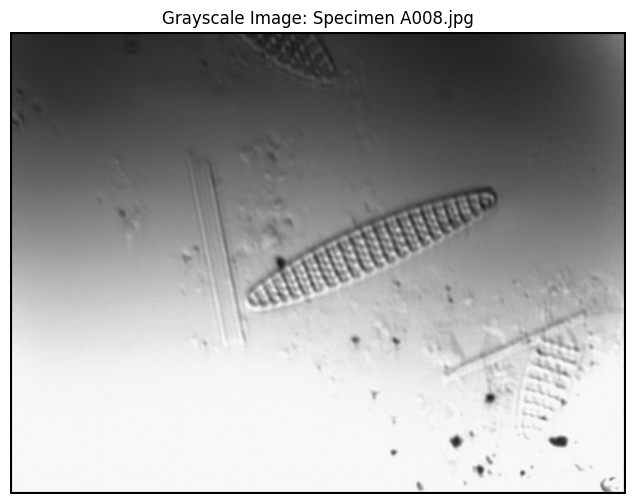

In [8]:

# Set the path to the specific image
img_path = "/content/ML_Projects/10_f_kerguelensis_photos/PC496_8_10cm_gpA008.jpg"

# Read the image
image = imread(img_path)

# Convert to grayscale
gray_image = rgb2gray(image)

# Display the grayscale image
fig, ax = plt.subplots(figsize=(8, 6))
ax.imshow(gray_image, cmap='gray')  # Use 'gray' colormap for grayscale images

# Add black border around the image
rect = patches.Rectangle((0, 0), gray_image.shape[1], gray_image.shape[0], linewidth=3, edgecolor="black", facecolor="none")
ax.add_patch(rect)

# Title and settings
ax.set_title("Grayscale Image: Specimen A008.jpg")
ax.axis('off')  # Turn off axis labels

plt.show()


A bit of an issue to correct.  The bottom is much brighter than the top.  Let's see if we can correct that at all by adding a Correct Lighting Bias

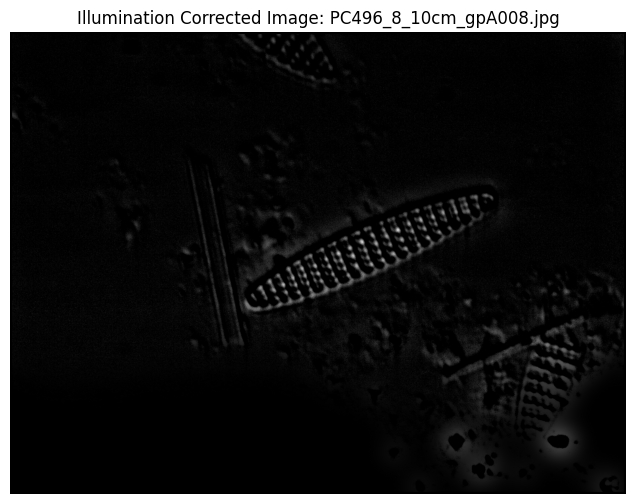

In [10]:

# Set the path to the specific image
img_path = "/content/ML_Projects/10_f_kerguelensis_photos/PC496_8_10cm_gpA008.jpg"

# Read the image
image = imread(img_path)

# Convert to grayscale
gray_image = rgb2gray(image)

# Step 1: Estimate the background (illumination gradient) using Gaussian filtering
background = filters.gaussian(gray_image, sigma=50)  # Adjust sigma for smoothness

# Step 2: Subtract the background from the image to correct lighting
corrected_bias_image = gray_image - background
corrected_bias_image = np.clip(corrected_bias_image, 0, 1)  # Ensure values stay within valid range [0, 1]

# Display the corrected image
fig, ax = plt.subplots(figsize=(8, 6))
ax.imshow(corrected_bias_image, cmap='gray')  # Show corrected image

# Add black border around the image
rect = patches.Rectangle((0, 0), corrected_bias_image.shape[1], corrected_bias_image.shape[0], linewidth=3, edgecolor="black", facecolor="none")
ax.add_patch(rect)

# Title and settings
ax.set_title("Illumination Corrected Image: PC496_8_10cm_gpA008.jpg")
ax.axis('off')  # Turn off axis labels

plt.show()


Correct Lighting Bias made it way too dark.  Lets try a gradient based correction

<ipython-input-11-d3f7e37dbd00>:14: RuntimeWarning: divide by zero encountered in divide
  corrected_image = gray_image / gradient[:, np.newaxis]  # Broadcast gradient across the columns


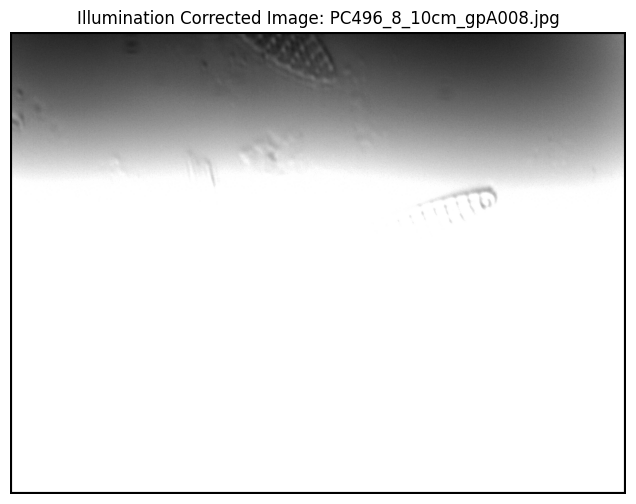

In [11]:

# Set the path to the specific image
img_path = "/content/ML_Projects/10_f_kerguelensis_photos/PC496_8_10cm_gpA008.jpg"

# Read the image
image = imread(img_path)

# Convert to grayscale
gray_image = rgb2gray(image)

# Step 1: Estimate the gradient along the vertical axis (bottom to top)
gradient = np.linspace(1, 0, gray_image.shape[0])  # Linear gradient from 1 (bottom) to 0 (top)

# Step 2: Apply the gradient correction
corrected_image = gray_image / gradient[:, np.newaxis]  # Broadcast gradient across the columns
corrected_image = np.clip(corrected_image, 0, 1)  # Ensure values stay within valid range [0, 1]

# Display the corrected image
fig, ax = plt.subplots(figsize=(8, 6))
ax.imshow(corrected_image, cmap='gray')  # Show corrected image

# Add black border around the image
rect = patches.Rectangle((0, 0), corrected_image.shape[1], corrected_image.shape[0], linewidth=3, edgecolor="black", facecolor="none")
ax.add_patch(rect)

# Title and settings
ax.set_title("Illumination Corrected Image: PC496_8_10cm_gpA008.jpg")
ax.axis('off')  # Turn off axis labels

plt.show()


Now its way too bright!  Let's see if we can equalize this at all.

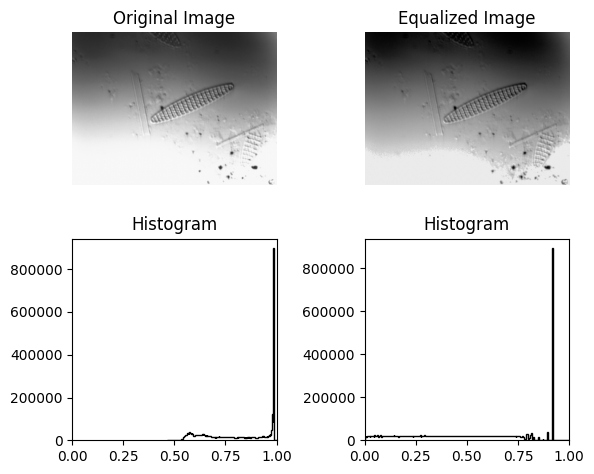

In [12]:

# Set the path to the specific image
img_path = "/content/ML_Projects/10_f_kerguelensis_photos/PC496_8_10cm_gpA008.jpg"

# Read the image
image = imread(img_path)

# Convert to grayscale
gray_image = rgb2gray(image)

# Step 1: Apply histogram equalization
equalized_image = exposure.equalize_hist(gray_image)

# Plotting the original and equalized images along with their histograms
fig, ax = plt.subplots(2, 2, figsize=(6, 5))

# Original Image
ax[0, 0].imshow(gray_image, cmap='gray')
ax[0, 0].set_title("Original Image")
ax[0, 0].axis('off')

# Equalized Image
ax[0, 1].imshow(equalized_image, cmap='gray')
ax[0, 1].set_title("Equalized Image")
ax[0, 1].axis('off')

# Original Histogram
ax[1, 0].hist(gray_image.ravel(), bins=256, histtype='step', color='black')
ax[1, 0].set_title("Histogram")
ax[1, 0].set_xlim(0, 1)

# Equalized Histogram
ax[1, 1].hist(equalized_image.ravel(), bins=256, histtype='step', color='black')
ax[1, 1].set_title("Histogram")
ax[1, 1].set_xlim(0, 1)

plt.tight_layout()
plt.show()


Lets try stretching the contrast

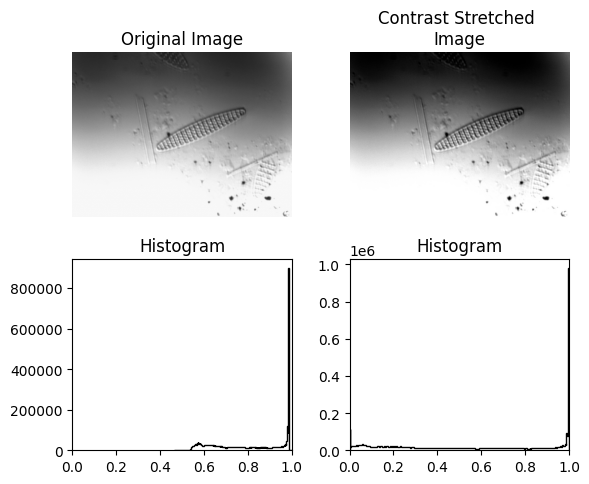

In [13]:

# Set the path to the specific image
img_path = "/content/ML_Projects/10_f_kerguelensis_photos/PC496_8_10cm_gpA008.jpg"

# Read the image
image = imread(img_path)

# Convert to grayscale
gray_image = rgb2gray(image)

# Step 1: Perform contrast stretching
p2, p98 = np.percentile(gray_image, (2, 98))  # Use the 2nd and 98th percentiles
contrast_stretched_image = exposure.rescale_intensity(gray_image, in_range=(p2, p98), out_range=(0, 1))

# Plotting the original and contrast-stretched images along with their histograms
fig, ax = plt.subplots(2, 2, figsize=(6, 5))

# Original Image
ax[0, 0].imshow(gray_image, cmap='gray')
ax[0, 0].set_title("Original Image")
ax[0, 0].axis('off')

# Contrast Stretched Image
ax[0, 1].imshow(contrast_stretched_image, cmap='gray')
ax[0, 1].set_title("Contrast Stretched \nImage")
ax[0, 1].axis('off')

# Original Histogram
ax[1, 0].hist(gray_image.ravel(), bins=256, histtype='step', color='black')
ax[1, 0].set_title("Histogram")
ax[1, 0].set_xlim(0, 1)

# Contrast Stretched Histogram
ax[1, 1].hist(contrast_stretched_image.ravel(), bins=256, histtype='step', color='black')
ax[1, 1].set_title("Histogram")
ax[1, 1].set_xlim(0, 1)

plt.tight_layout()
plt.show()


Lets try logarithmic contrast.

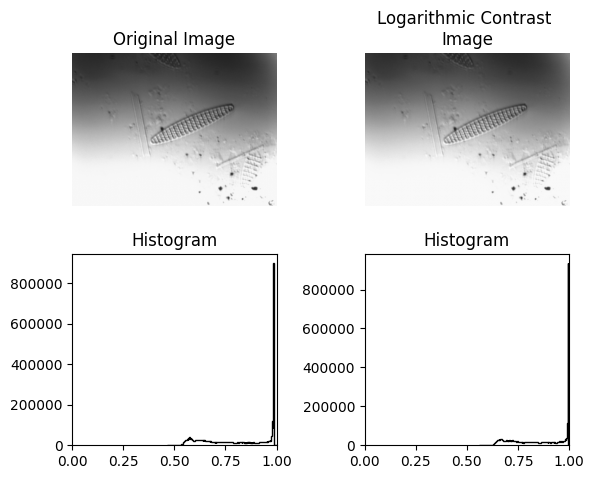

In [14]:

# Set the path to the specific image
img_path = "/content/ML_Projects/10_f_kerguelensis_photos/PC496_8_10cm_gpA008.jpg"

# Read the image
image = imread(img_path)

# Convert to grayscale
gray_image = rgb2gray(image)

# Step 1: Apply logarithmic contrast stretching
log_image = exposure.adjust_log(gray_image + 0.01)  # Adding a small constant to avoid log(0)

# Plotting the original and logarithmically stretched images along with their histograms
fig, ax = plt.subplots(2, 2, figsize=(6, 5))

# Original Image
ax[0, 0].imshow(gray_image, cmap='gray')
ax[0, 0].set_title("Original Image")
ax[0, 0].axis('off')

# Logarithmic Image
ax[0, 1].imshow(log_image, cmap='gray')
ax[0, 1].set_title("Logarithmic Contrast \nImage")
ax[0, 1].axis('off')

# Original Histogram
ax[1, 0].hist(gray_image.ravel(), bins=256, histtype='step', color='black')
ax[1, 0].set_title("Histogram")
ax[1, 0].set_xlim(0, 1)

# Logarithmic Histogram
ax[1, 1].hist(log_image.ravel(), bins=256, histtype='step', color='black')
ax[1, 1].set_title("Histogram")
ax[1, 1].set_xlim(0, 1)

plt.tight_layout()
plt.show()


#Lighting Correction So Far
So far, we have tried a whole bunch of kinds of lighting corrections.  I have been trying to get it so one side of the image is a similar hue as they other, instead of having the big dark spot at the top and the big light spot below.  I have only been marginally successful, but I would say the histogram equalized image has brought out the most discernable detail in the photo, so we'll use that one for the rest of this analysis.

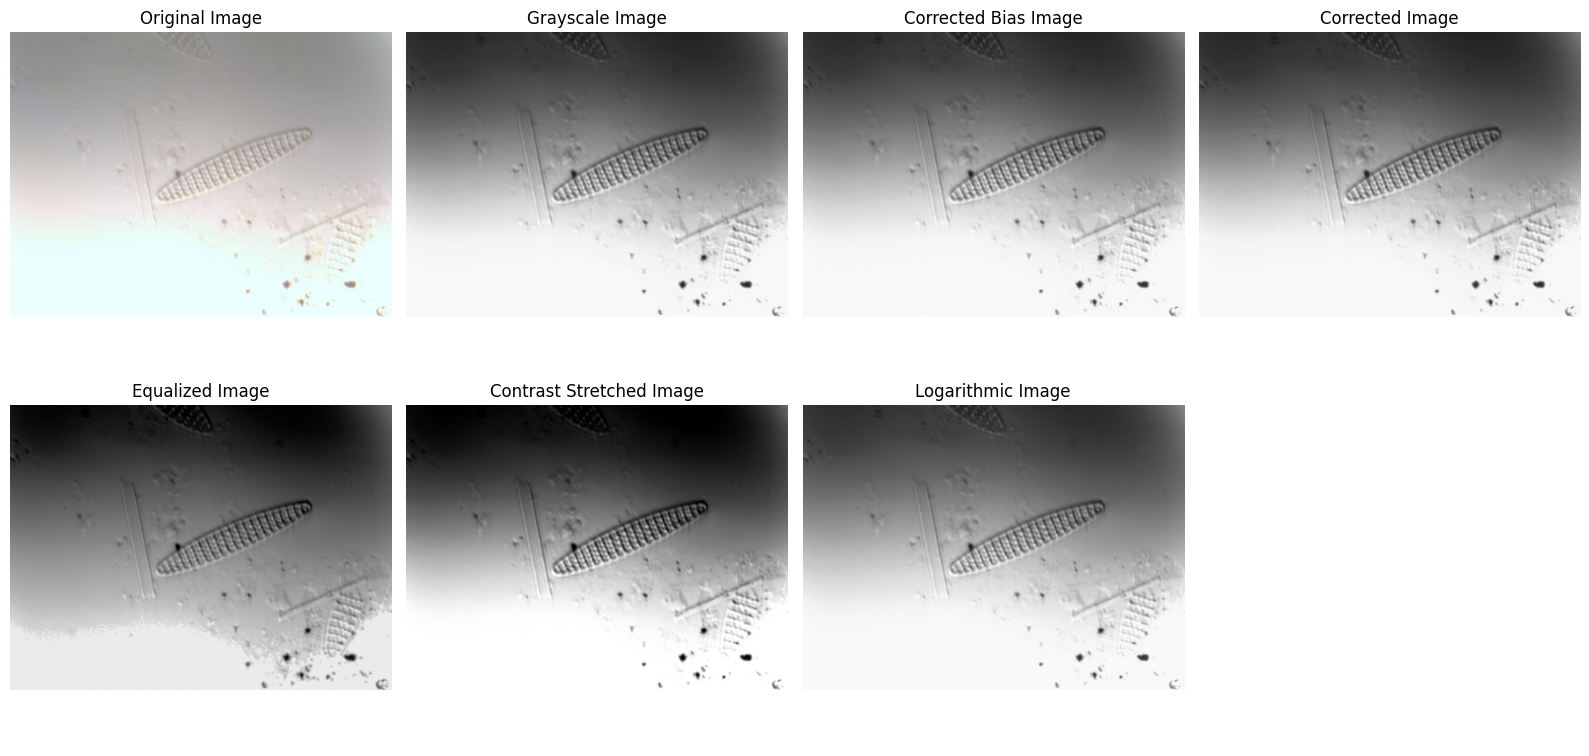

In [15]:

# Set the path to the specific image
img_path = "/content/ML_Projects/10_f_kerguelensis_photos/PC496_8_10cm_gpA008.jpg"

# Read the image
image = imread(img_path)

# Convert to grayscale
gray_image = rgb2gray(image)

# Correcting image brightness (bias correction)
corrected_bias_image = exposure.adjust_gamma(gray_image, gamma=0.8)

# Perform contrast stretching (percentile-based method)
p2, p98 = np.percentile(gray_image, (2, 98))  # Use the 2nd and 98th percentiles
contrast_stretched_image = exposure.rescale_intensity(gray_image, in_range=(p2, p98), out_range=(0, 1))

# Apply logarithmic contrast stretching
log_image = exposure.adjust_log(gray_image + 0.01)  # Adding a small constant to avoid log(0)

# Histogram Equalization
equalized_image = exposure.equalize_hist(gray_image)

# Plotting all images in a single figure
fig, ax = plt.subplots(2, 4, figsize=(16, 8))

# Original Image
ax[0, 0].imshow(image)
ax[0, 0].set_title("Original Image")
ax[0, 0].axis('off')

# Grayscale Image
ax[0, 1].imshow(gray_image, cmap='gray')
ax[0, 1].set_title("Grayscale Image")
ax[0, 1].axis('off')

# Bias-Corrected Image
ax[0, 2].imshow(corrected_bias_image, cmap='gray')
ax[0, 2].set_title("Corrected Bias Image")
ax[0, 2].axis('off')

# Corrected Image
ax[0, 3].imshow(gray_image, cmap='gray')  # Placeholder for the "corrected" version
ax[0, 3].set_title("Corrected Image")
ax[0, 3].axis('off')

# Equalized Image
ax[1, 0].imshow(equalized_image, cmap='gray')
ax[1, 0].set_title("Equalized Image")
ax[1, 0].axis('off')

# Contrast Stretched Image
ax[1, 1].imshow(contrast_stretched_image, cmap='gray')
ax[1, 1].set_title("Contrast Stretched Image")
ax[1, 1].axis('off')

# Logarithmic Contrast Image
ax[1, 2].imshow(log_image, cmap='gray')
ax[1, 2].set_title("Logarithmic Image")
ax[1, 2].axis('off')

# Empty placeholder for the 8th plot
ax[1, 3].axis('off')

plt.tight_layout()
plt.show()


#Part 2: Edge Detection
Canny edge detection "looks" for edges in a photo by assessing rapid changes in intensity, which is why we needed to *a)* have a greyscale photo and *b)* play around with the lighting to bring out as much detail as possible.  Lets now use canny edge detection to try and "find" the edge of the diatom in this photo

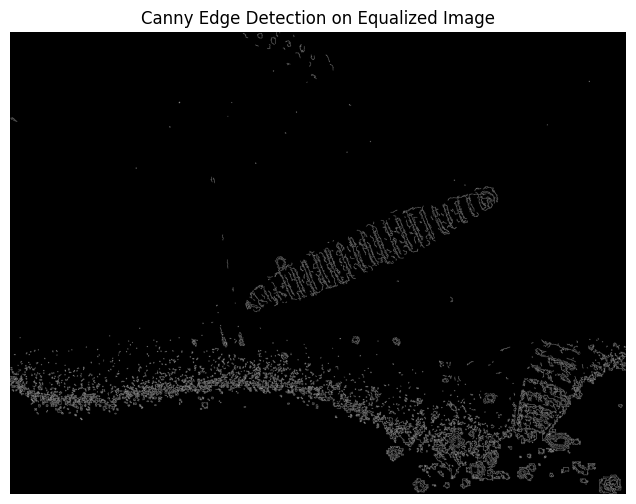

In [16]:

# Apply Canny edge detection to the equalized image
edges = canny(equalized_image)

# Display the edge-detected image
plt.figure(figsize=(8, 6))
plt.imshow(edges, cmap='gray')
plt.title("Canny Edge Detection on Equalized Image")
plt.axis('off')  # Turn off axis labels
plt.show()


Interesting.  This is not entirely unexpected, but the canny edge detector has picked out the internal areolae of the specimen rather than the outside, and it has aso picked out a band of sediment that was on the microscope slide.  Lets try sobel edge detection, which uses the gradient of image intensity.

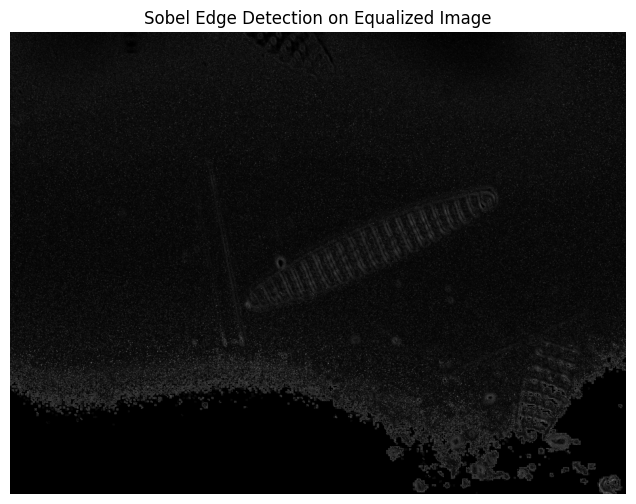

In [17]:

# Apply Sobel edge detection
edges_sobel = sobel(equalized_image)

# Display the Sobel edge-detected image
plt.figure(figsize=(8, 6))
plt.imshow(edges_sobel, cmap='gray')
plt.title("Sobel Edge Detection on Equalized Image")
plt.axis('off')  # Turn off axis labels
plt.show()


It would seem we picked out a bit more fine detail.  Lets try a LaPlacian of Gaussian (LoG) next

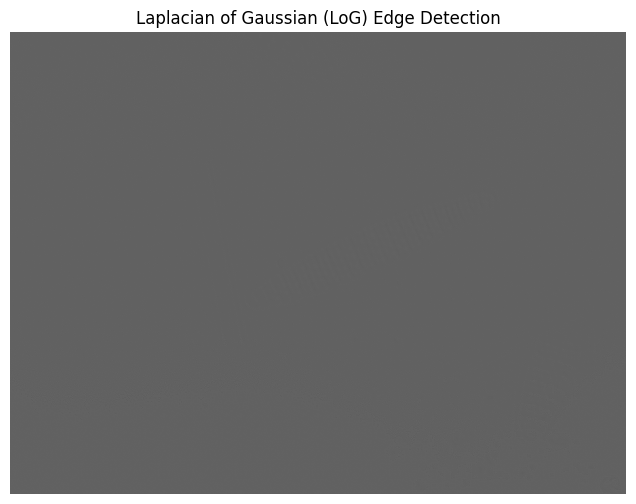

In [18]:

# Convert the image to float (if not already) for laplace filtering
float_image = img_as_float(equalized_image)

# Apply Laplacian of Gaussian edge detection
edges_log = laplace(float_image)

# Display the Laplacian of Gaussian edge-detected image
plt.figure(figsize=(8, 6))
plt.imshow(edges_log, cmap='gray')
plt.title("Laplacian of Gaussian (LoG) Edge Detection")
plt.axis('off')  # Turn off axis labels
plt.show()


That didn't do anything.  Last one, a Roberts Cross Operator

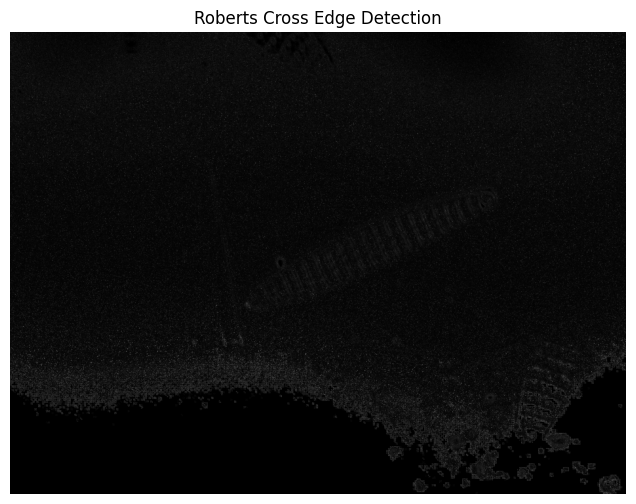

In [19]:

# Apply Roberts Cross edge detection
edges_roberts = roberts(equalized_image)

# Display the Roberts edge-detected image
plt.figure(figsize=(8, 6))
plt.imshow(edges_roberts, cmap='gray')
plt.title("Roberts Cross Edge Detection")
plt.axis('off')  # Turn off axis labels
plt.show()


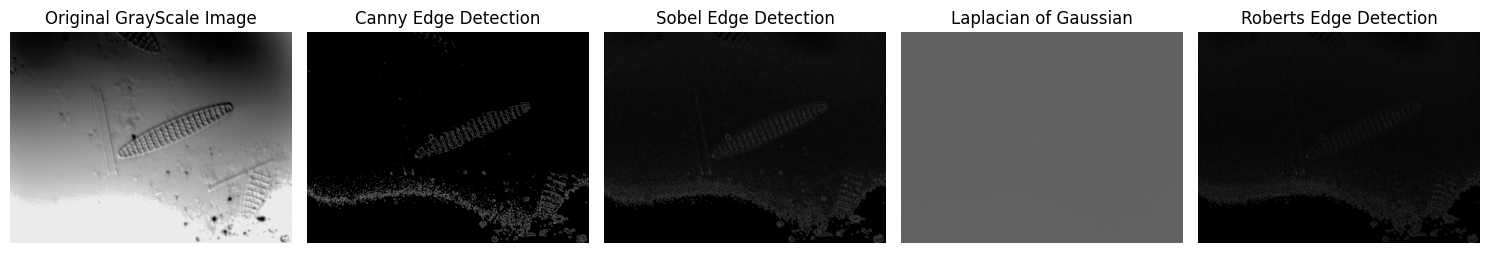

In [24]:
# Edge detection methods
edges_canny = canny(equalized_image)
edges_sobel = sobel(equalized_image)

edges_log = laplace(img_as_float(equalized_image))  # Convert to float for LoG
edges_roberts = roberts(equalized_image)

# Set up the plotting grid (2x3 grid)
fig, axes = plt.subplots(1, 5, figsize=(15, 10))

# Plot the original image
axes[0].imshow(equalized_image, cmap='gray')
axes[0].set_title('Original GrayScale Image')
axes[0].axis('off')

# Plot Canny edge detection
axes[1].imshow(edges_canny, cmap='gray')
axes[1].set_title('Canny Edge Detection')
axes[1].axis('off')

# Plot Sobel edge detection
axes[2].imshow(edges_sobel, cmap='gray')
axes[2].set_title('Sobel Edge Detection')
axes[2].axis('off')


# Plot Laplacian of Gaussian (LoG) edge detection
axes[3].imshow(edges_log, cmap='gray')
axes[3].set_title('Laplacian of Gaussian')
axes[3].axis('off')

# Plot Roberts Cross edge detection
axes[4].imshow(edges_roberts, cmap='gray')
axes[4].set_title('Roberts Edge Detection')
axes[4].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()


Visually, it seems like our canny edge detector picked out the most detail in this dataset, but we can actually combine these tools to get a bit more detail. Here is both canny edge and sobel edge detector.

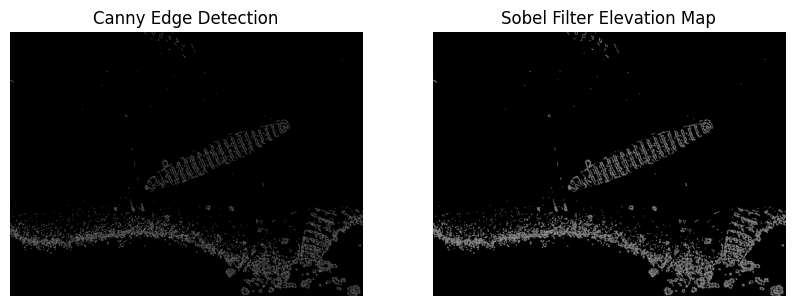

In [25]:

# Step 2: Apply Sobel filter on the edges to create an elevation map
elevation_map = filters.sobel(edges_canny)

# Visualize the edges and elevation map
plt.figure(figsize=(10, 8))

plt.subplot(1, 2, 1)
plt.imshow(edges_canny, cmap='gray')
plt.title("Canny Edge Detection")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(elevation_map, cmap='gray')
plt.title("Sobel Filter Elevation Map")
plt.axis('off')

plt.show()




##Part 3: Image Analysis and Contouring
---



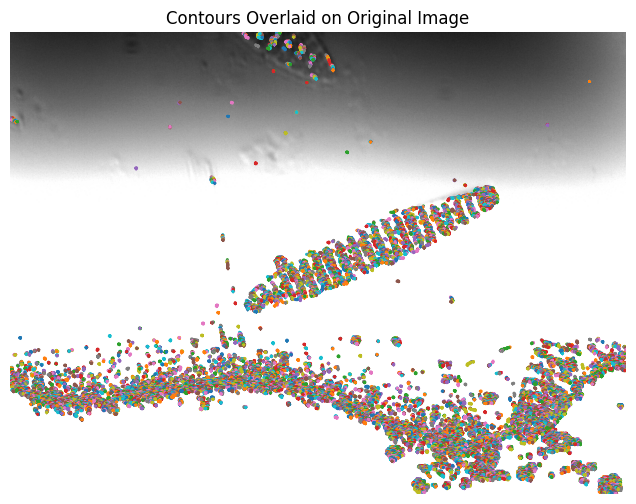

In [26]:

# Step 1: Apply Canny edge detection
edges_canny = feature.canny(equalized_image)

# Step 2: Find contours from the edge-detected image
contours = measure.find_contours(edges_canny, level=0.5)

# Step 3: Create a plot to display the contours
plt.figure(figsize=(8, 6))
plt.imshow(corrected_image, cmap='gray')
plt.title("Contours Overlaid on Original Image")

# Plot the contours
for contour in contours:
    plt.plot(contour[:, 1], contour[:, 0], linewidth=2)

plt.axis('off')  # Turn off axis labels
plt.show()




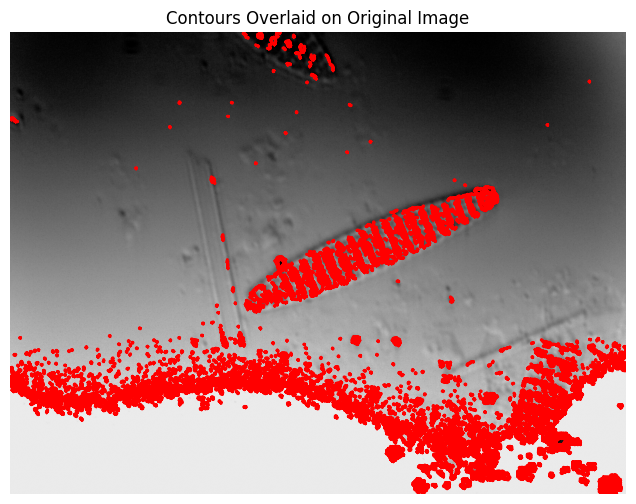

In [27]:
# Step 3: Create a plot to display the contours
plt.figure(figsize=(8, 6))
plt.imshow(equalized_image, cmap='gray')
plt.title("Contours Overlaid on Original Image")

# Plot the contours as continuous lines (with no dots)
for contour in contours:
    plt.plot(contour[:, 1], contour[:, 0], linewidth=2, color='r')  # red line

plt.axis('off')  # Turn off axis labels
plt.show()


So while it looks like a bunch of dots, each little dot represents a contour thats so small it appears as dots.  This highlights an issue when trying to perform image analysis on organic objects.  They are really complicated, and computer algorithms don't always have the greatest ability to pick them out.

##What have we done so far
We have taken our original image, converted it to grayscale, applied some equalization to get more detail out of the image, performed edge detection, and attempted to contour the diatom in the image.  We have so far been unsuccessful in our attempts to contour the diatom.

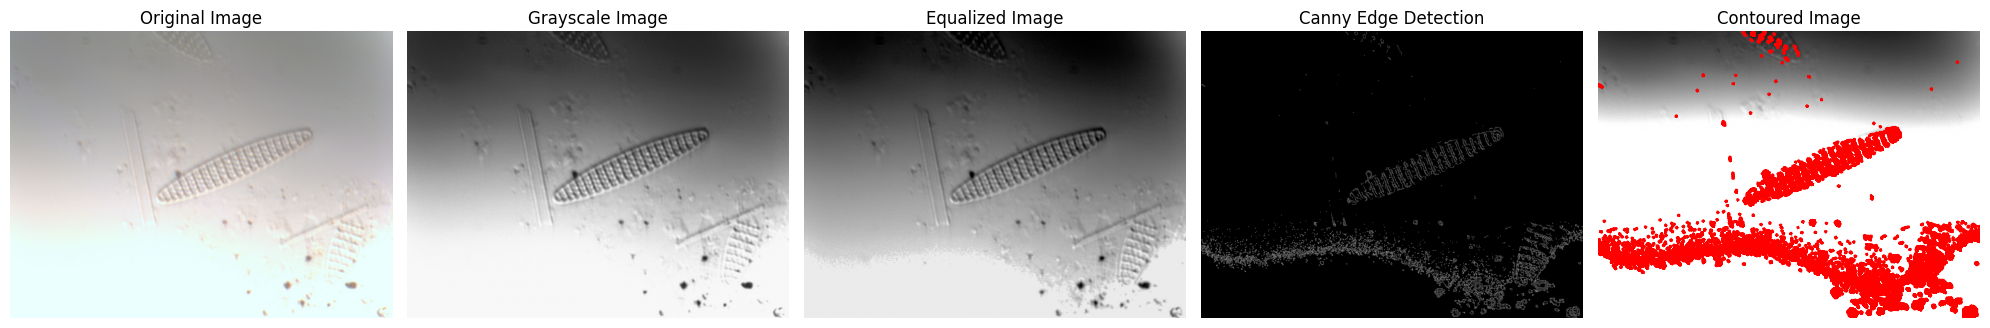

In [28]:
# Create a figure with subplots for displaying the images
plt.figure(figsize=(20, 6))

# Original Image
plt.subplot(1, 5, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis('off')

# Grayscale Image
plt.subplot(1, 5, 2)
plt.imshow(gray_image, cmap='gray')
plt.title("Grayscale Image")
plt.axis('off')

# Equalized Image
plt.subplot(1, 5, 3)
plt.imshow(equalized_image, cmap='gray')
plt.title("Equalized Image")
plt.axis('off')

# Canny Edge Detection
plt.subplot(1, 5, 4)
plt.imshow(edges_canny, cmap='gray')
plt.title("Canny Edge Detection")
plt.axis('off')

# Contoured Image
plt.subplot(1, 5, 5)
plt.imshow(corrected_image, cmap='gray')
for contour in contours:
    step = 5  # Reduce resolution of contour for smoother visualization
    plt.plot(contour[::step, 1], contour[::step, 0], linewidth=2, color='r')  # red contour
plt.title("Contoured Image")
plt.axis('off')

plt.tight_layout()
plt.show()


To finish, lets see if we can merge these contours to actually measure what we want to measures

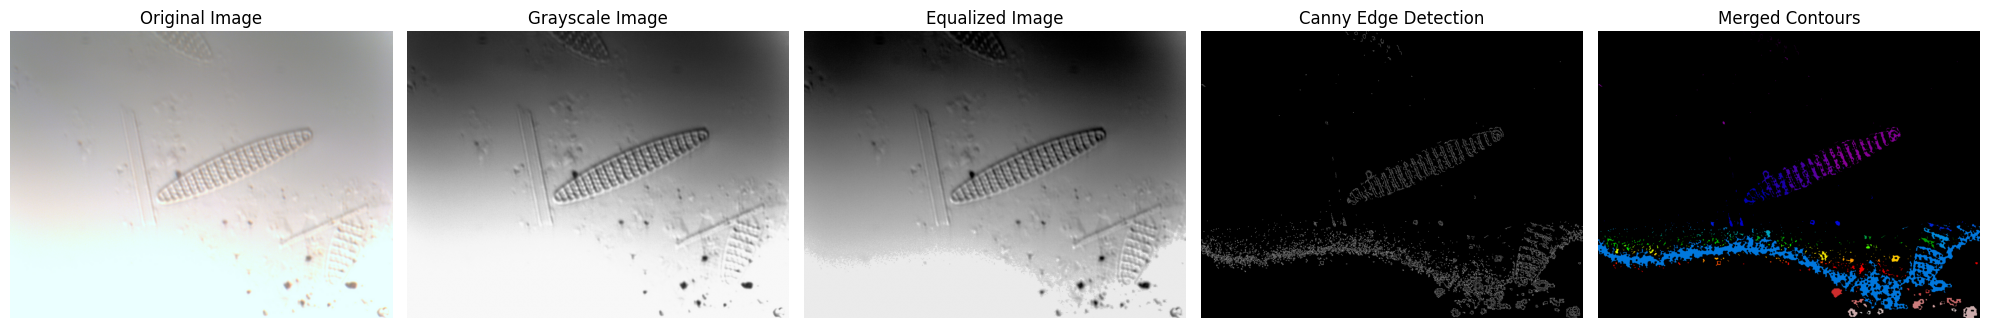

In [29]:

# Step 1: Create a binary image with the contours (edge image)
binary_image = edges_canny > 0  # This will be your edge detection output

# Step 2: Apply morphological closing to merge adjacent contours
merged_contours = morphology.closing(binary_image, morphology.disk(5))  # You can adjust the disk size for larger merging

# Step 3: Label the merged regions to get distinct objects
labeled_image = label(merged_contours)

# Step 4: Plot the images
plt.figure(figsize=(20, 6))

# Original Image
plt.subplot(1, 5, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis('off')

# Grayscale Image
plt.subplot(1, 5, 2)
plt.imshow(gray_image, cmap='gray')
plt.title("Grayscale Image")
plt.axis('off')

# Equalized Image
plt.subplot(1, 5, 3)
plt.imshow(equalized_image, cmap='gray')
plt.title("Equalized Image")
plt.axis('off')

# Canny Edge Detection
plt.subplot(1, 5, 4)
plt.imshow(edges_canny, cmap='gray')
plt.title("Canny Edge Detection")
plt.axis('off')

# Merged Contours Image
plt.subplot(1, 5, 5)
plt.imshow(labeled_image, cmap='nipy_spectral')  # Use a color map to show distinct labeled regions
plt.title("Merged Contours")
plt.axis('off')

plt.tight_layout()
plt.show()


(-0.5, 2591.5, 1943.5, -0.5)

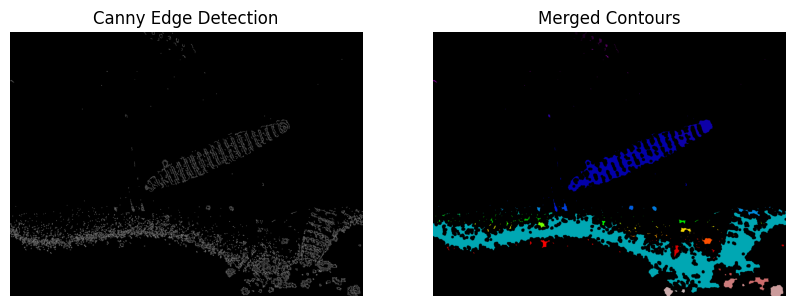

In [30]:
# Step 1: Create a binary image with the contours (edge image)
binary_image = edges_canny > 0  # This will be your edge detection output

# Step 2: Apply morphological closing to merge adjacent contours
merged_contours = morphology.closing(binary_image, morphology.disk(10))  # You can adjust the disk size for larger merging

# Step 3: Label the merged regions to get distinct objects
labeled_image = label(merged_contours)


plt.figure(figsize=(10,6))
# Canny Edge Detection
plt.subplot(1, 2, 1)
plt.imshow(edges_canny, cmap='gray')
plt.title("Canny Edge Detection")
plt.axis('off')

# Merged Contours Image
plt.subplot(1, 2, 2)
plt.imshow(labeled_image, cmap='nipy_spectral')  # Use a color map to show distinct labeled regions
plt.title("Merged Contours")
plt.axis('off')


Thats kind of cool!  We havent fully captured the diatom outline, but we have successfully merged all the contours that made up the original body.  We also identified the band of sediment as one object. Lets see if we can get any more detail.

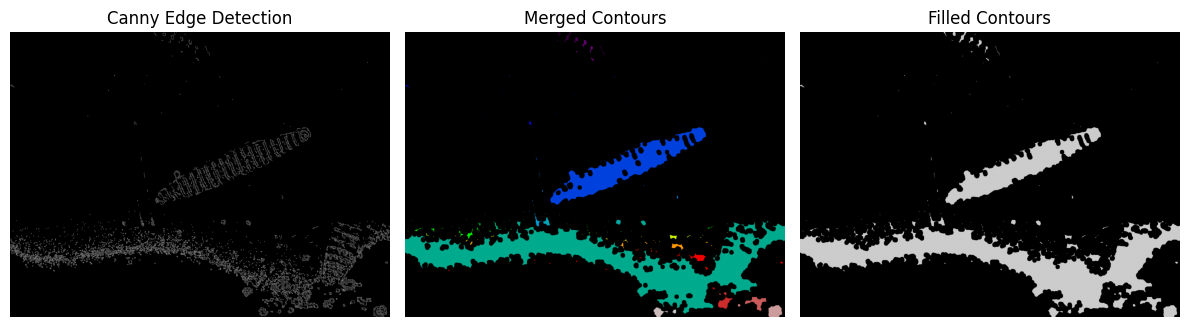

In [31]:

# Step 1: Create a binary image with the contours (edge image)
binary_image = edges_canny > 0  # This will be your edge detection output

# Step 2: Apply morphological closing to merge adjacent contours
merged_contours = morphology.closing(binary_image, morphology.disk(15))  # You can adjust the disk size for larger merging

# Step 3: Label the merged regions to get distinct objects
labeled_image = label(merged_contours)

# Step 4: Fill the holes within each object (region)
filled_image = ndimage.binary_fill_holes(labeled_image)

# Visualize the results
plt.figure(figsize=(12, 6))

# Canny Edge Detection
plt.subplot(1, 3, 1)
plt.imshow(edges_canny, cmap='gray')
plt.title("Canny Edge Detection")
plt.axis('off')

# Merged Contours
plt.subplot(1, 3, 2)
plt.imshow(labeled_image, cmap='nipy_spectral')  # Use a color map to show distinct labeled regions
plt.title("Merged Contours")
plt.axis('off')

# Filled Contours
plt.subplot(1, 3, 3)
plt.imshow(filled_image, cmap='nipy_spectral')  # Same colormap to show distinct filled regions
plt.title("Filled Contours")
plt.axis('off')

plt.tight_layout()
plt.show()


**Conclusion:**  While I was not successful in completely isolating the diatom body in enough detail to measure, I was successful in isolating the body itself from all the other stuff that was on the microscope slide.  Canny edge detection worked the best, but not completely.  From this exercise, I conclude that performing image segmentation on organic forms is really challenging because of their complexity.  
I thought that the segmentation aspect of this assignment was interesting.  This is probably the most useful to anyone trying to do quantitative anlaysis using images, because it allows you to potentially isolate just the aspects that you want to measure.  However, this should be done with caution as clearly organic shapes are challenging to segment.  The merge and fill aspect was also really interesting.  This could allow you to group aspects of an image by like, and I could see this being useful to do a point counting type of problem.
One thing I wanted to use but couldn't get to work was doing watershed topography.  This should be a feature that could be really useful, where it basically turns an image into a topographic map. But I couldn't get this to work.  
Overall, I think that I would use this tool to do bedform analysis using multibeam on the seafloor. It would be useful to compare bedforms and even establish a framework for some kind of automated bedform analysis.  Multibeam investigation is often very dependent on the observer having knowledge of what a bedform "should" look like, and it can be challenging when multiple bedforms are on top of each other (like when iceberg furrows overly corrugation ridges).  I could see trying to use this tool to try and quantify these bedforms using a computational approach.  I think that an algorithm would be better at picking out bedforms than it would be at picking our organic forms, so this approach would be more appropriate on the seafloor or in rivers or something like that than the way I used it in this excersize.